In [ ]:
import os
import gc
import pickle 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from torch.cuda.amp import autocast, GradScaler 

warnings.filterwarnings("ignore")

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on: {DEVICE}")

# Global
DATASET = 'CIFAR-10'  # or 'MNIST'
BATCH_SIZE = 256

Running on: cuda


In [ ]:
class TwoCropTransform:
    """Tạo 2 góc nhìn (views) cho thuật toán SimCLR"""
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

class GaussianBlur(object):
    """Gaussian Blur augmentation (SimCLR)."""
    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

class IdentityTransform(object):
    def __call__(self, img):
        return img

def get_brb_transform(dataset_name, is_contrastive=False, train=True):
    # Group 1: GRAYSCALE
    if dataset_name in ['MNIST', 'KMNIST', 'Fashion-MNIST', 'USPS', 'OPTDIGITS']:
        if train:
            transform_list = [
                transforms.ToPILImage() if dataset_name == 'OPTDIGITS' else IdentityTransform(),
                transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ]
        else:
            transform_list = [
                transforms.ToPILImage() if dataset_name == 'OPTDIGITS' else IdentityTransform(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ]
        final_transform = transforms.Compose(transform_list)

    # Group 2: COLOR (CIFAR-10, etc.)
    elif dataset_name in ['CIFAR-10', 'CIFAR-100-20', 'GTSRB']:
        normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
        input_size = 32
        if train:
            final_transform = transforms.Compose([
                transforms.RandomResizedCrop(size=input_size, scale=(0.2, 1.)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
                transforms.RandomGrayscale(p=0.2),
                transforms.ToTensor(),
                normalize,
            ])
        else:
            final_transform = transforms.Compose([
                transforms.Resize((input_size, input_size)) if dataset_name == 'GTSRB' else IdentityTransform(),
                transforms.ToTensor(),
                normalize,
            ])
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    if is_contrastive and train:
        return TwoCropTransform(final_transform)
    return final_transform

In [24]:
class OptDigitsDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = torch.tensor(data, dtype=torch.float32).view(-1, 8, 8)
        self.targets = torch.tensor(targets, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

class GTSRBDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx]['Path'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.data.iloc[idx]['ClassId'])
        if self.transform:
            image = self.transform(image)
        return image, label

class CIFAR100Coarse(Dataset):
    """
    Wrapper mapping CIFAR-100 (100 classes) -> CIFAR-100-20 (20 superclasses).
    """
    def __init__(self, root, train, transform, download):
        self.dataset = datasets.CIFAR100(root=root, train=train, transform=transform, download=download)

        # Hardcoded mapping from Fine (0-99) to Coarse (0-19)
        self.coarse_map = np.array([
            4, 1, 14, 8, 0, 6, 7, 7, 18, 3, 3, 14, 9, 18, 7, 11, 3, 9, 7, 11,
            6, 11, 5, 10, 7, 6, 13, 15, 3, 15, 0, 11, 1, 10, 12, 14, 16, 9, 11, 5,
            5, 19, 8, 8, 15, 13, 14, 17, 18, 10, 16, 4, 17, 4, 2, 0, 17, 4, 18, 17,
            10, 3, 2, 12, 12, 16, 12, 1, 9, 19, 2, 10, 0, 1, 16, 12, 9, 13, 15, 13,
            16, 19, 2, 4, 6, 19, 5, 5, 8, 19, 18, 1, 2, 15, 6, 0, 17, 8, 14, 13
        ])

        # Pre-calculate coarse labels
        self.targets = [self.coarse_map[y] for y in self.dataset.targets]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # self.dataset[idx] applied transform
        img, _ = self.dataset[idx]
        return img, self.targets[idx]

In [ ]:
def get_data_loaders(dataset_name, batch_size=256, is_contrastive=False):
    root = './datasets'

    if dataset_name in ['MNIST', 'USPS']:
        train_transform = transforms.Compose([transforms.RandomAffine(10, (0.1,0.1), (0.9,1.1)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    elif dataset_name in ['CIFAR-10', 'GTSRB']:
        norm = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(32,(0.2,1.)), transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2), transforms.ToTensor(), norm
        ])
        test_transform = transforms.Compose([transforms.ToTensor(), norm])

    if is_contrastive: train_transform = TwoCropTransform(train_transform)

    if dataset_name == 'MNIST':
        train_ds = datasets.MNIST(root, True, download=True, transform=train_transform)
        test_ds = datasets.MNIST(root, False, download=True, transform=test_transform)
    elif dataset_name == 'CIFAR-10':
        train_ds = datasets.CIFAR10(root, True, download=True, transform=train_transform)
        test_ds = datasets.CIFAR10(root, False, download=True, transform=test_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True,
                              num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=4, pin_memory=True, persistent_workers=True)

    return train_loader, test_loader

**Models**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')



# FEED-FORWARD AUTOENCODER (Group 1: ['MNIST', 'KMNIST', 'Fashion-MNIST', 'USPS', 'OPTDIGITS', etc.)
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 500), nn.ReLU(),
            nn.Linear(500, 500), nn.ReLU(),
            nn.Linear(500, 2000), nn.ReLU(),
            nn.Linear(2000, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2000), nn.ReLU(),
            nn.Linear(2000, 500), nn.ReLU(),
            nn.Linear(500, 500), nn.ReLU(),
            nn.Linear(500, input_dim)
        )
        self.apply(init_weights)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        return self.decoder(z), z
# RESNET-18 BACKBONE (Group 2: CIFAR-10, GTSRB)

class ContrastiveResNet18(nn.Module):
    def __init__(self, latent_dim=128):
        super(ContrastiveResNet18, self).__init__()
        backbone = resnet18(weights=None)
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1, bias=False),
            backbone.bn1, backbone.relu, 
            backbone.layer1, backbone.layer2, backbone.layer3, backbone.layer4,
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.projector = nn.Sequential(nn.Linear(512, 512), nn.ReLU(), nn.Linear(512, latent_dim))
        self.apply(init_weights)
    def forward(self, x):
        h = self.backbone(x).flatten(1)
        z = self.projector(h)
        return h, z

**metrics**

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t().detach()

def cluster_acc(y_true, y_pred):
    """
    Args:
        y_true (np.array): Ground Truth
        y_pred (np.array): Predicted Clusters

    Returns:
        float: Accuracy [0, 1].
    """
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)

    # Size of  y_pred and y_true must same
    assert y_pred.size == y_true.size

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)

    # Confusion Matrix
    # w[i, j] = number of samples belonging to cluster i but with actual label j
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    accuracy = sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size

    return accuracy

def evaluate_clustering(y_true, y_pred):
    """
    Calculate all the key metrics for Deep Clustering.

    Args:
        y_true (np.array): Ground Truth
        y_pred (np.array): Predicted Clusters

    Returns:
        dict: Dictionary contain {'ACC': float, 'NMI': float, 'ARI': float}
    """
    if hasattr(y_true, 'cpu'): y_true = y_true.cpu().numpy()
    if hasattr(y_pred, 'cpu'): y_pred = y_pred.cpu().numpy()
    if isinstance(y_true, list): y_true = np.array(y_true)
    if isinstance(y_pred, list): y_pred = np.array(y_pred)

    # Accuracy (ACC)
    acc = cluster_acc(y_true, y_pred)

    # Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(y_true, y_pred)

    # Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(y_true, y_pred)

    return {
        'ACC': np.round(acc, 4),
        'NMI': np.round(nmi, 4),
        'ARI': np.round(ari, 4)
    }


class NTXentLoss(nn.Module): # SimCLR Loss
    def __init__(self, batch_size, temperature=0.5, device='cuda'):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)
        self.mask = self.mask_correlated_samples(batch_size)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        N = 2 * self.batch_size
        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        labels = torch.zeros(N).to(self.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        return self.criterion(logits, labels) / N

def calculate_metrics_gpu(model, loader, device, prev_preds=None, is_contrastive=False):
    # 1. Get Features & Labels (GPU)
    feats, targets = get_features_gpu(model, loader, device, is_contrastive)

    # 2. Predict Labels (GPU)
    if hasattr(model, 'clustering_layer'):
        preds = model.clustering_layer(feats).argmax(1)
    else:
        # Fallback KMeans CPU 
        feats_cpu = feats.cpu().numpy()
        km = KMeans(n_clusters=len(torch.unique(targets))).fit(feats_cpu)
        preds = torch.tensor(km.labels_).to(device)

    N = feats.shape[0]
    if N > 2000:
        idx = torch.randperm(N)[:2000].to(device)
        f_sub = feats[idx]; p_sub = preds[idx]
    else:
        f_sub = feats; p_sub = preds

    d_mat = torch.cdist(f_sub, f_sub)
    intra_dists = []
    unique_labels = torch.unique(p_sub)
    for k in unique_labels:
        mask = (p_sub == k)
        if mask.sum() > 1:
            intra_dists.append(d_mat[mask][:, mask].mean())
    intra = torch.tensor(intra_dists).mean().item() if intra_dists else 0.0

    # 4. ACC (CPU - Nhẹ)
    p_cpu = preds.cpu().numpy(); t_cpu = targets.cpu().numpy()
    D = max(p_cpu.max(), t_cpu.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(p_cpu.size): w[p_cpu[i], t_cpu[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    acc = sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / p_cpu.size

    # 5. Label Change (GPU)
    change = 0.0
    if prev_preds is not None:
        L = min(len(preds), len(prev_preds))
        change = (preds[:L] != prev_preds[:L]).float().mean().item() * 100.0

    return {'ACC': acc, 'Intra': intra, 'Change': change, 'Preds': preds}

**dec**

In [28]:
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, n_z, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.centroids = nn.Parameter(torch.Tensor(n_clusters, n_z))
        nn.init.xavier_normal_(self.centroids.data)
        self.alpha = alpha
    def forward(self, z):
        diff = z.unsqueeze(1) - self.centroids.unsqueeze(0)
        q = 1.0 + (torch.sum(diff**2, dim=2) / self.alpha)
        q = torch.pow(q, -(self.alpha + 1.0) / 2.0)
        return torch.div(q, torch.sum(q, dim=1, keepdim=True))

    def forward(self, z):
        """
        Compute Soft Assignment (Q) :  latent z and centroids.
        Input: z (batch_size, n_z)
        Output: q (batch_size, n_clusters)
        """
        diff = z.unsqueeze(1) - self.centroids.unsqueeze(0)
        squared_dist = torch.sum(diff**2, dim=2) # (batch, n_clusters)

        q = 1.0 + (squared_dist / self.alpha)
        q = torch.pow(q, -(self.alpha + 1.0) / 2.0)

        # Normalize
        q = torch.div(q, torch.sum(q, dim=1, keepdim=True))

        return q

def target_distribution(q):
    weight = q**2 / q.sum(0)
    p = (weight.t() / weight.sum(1)).t()
    return p.detach()

def kl_divergence_loss(q, p):
    """
    KL Divergence Loss: KL(P || Q) = sum(p * log(p/q))
    """
    return F.kl_div(torch.log(q), p, reduction='batchmean')

**idec**

In [ ]:
class IDEC(nn.Module):
    """
    Improved Deep Embedded Clustering (IDEC).
    combine Autoencoder + Clustering Layer.
    """
    def __init__(self, autoencoder, n_clusters, alpha=1.0):
        super(IDEC, self).__init__()
        self.autoencoder = autoencoder
        self.n_clusters = n_clusters
        self.alpha = alpha

        self.latent_dim = autoencoder.embedding_layer.out_features

        # init Clustering Layer (similar DEC)
        self.clustering_layer = ClusteringLayer(self.n_clusters, self.latent_dim, self.alpha)

    def forward(self, x):
        """
        Forward pass.
        Input: x
        Output:
            - x_recon: Reconstructed image (for calculating L_rec)
            - q: Soft distribution (for calculating L_clus)
            - z: Latent vector
        """
        # Autoencoder
        x_recon, z = self.autoencoder(x)

        # Clustering Layer
        q = self.clustering_layer(z)

        return x_recon, q, z

class IDEC_Contrastive(nn.Module):
    
    def __init__(self, backbone, n_clusters, alpha=1.0):
        super(IDEC_Contrastive, self).__init__()
        self.backbone = backbone
        self.n_clusters = n_clusters
        self.alpha = alpha

        dummy_input = torch.randn(1, 3, 32, 32)
        _, dummy_z = self.backbone(dummy_input)
        self.latent_dim = dummy_z.shape[1]

        self.clustering_layer = ClusteringLayer(self.n_clusters, self.latent_dim, self.alpha)

    def forward(self, x):
        if isinstance(x, list) or isinstance(x, tuple):
            view1, view2 = x
            _, z1 = self.backbone(view1)
            _, z2 = self.backbone(view2)
            q1 = self.clustering_layer(z1)
            return z1, z2, q1

        else:
            _, z = self.backbone(x)
            q = self.clustering_layer(z)
            return z, q

def idec_loss_function(x, x_recon, q, p, gamma=0.1):
    """
    IDEC: L = L_rec + gamma * L_clus

    Args:
        x: origin img
        x_recon: Reconstructed image from Decoder.
        q: Soft assignment from Clustering Layer.
        p: Target distribution.
        gamma: hyperparameter.

    Returns:
        total_loss, reconstruction_loss, clustering_loss
    """
    # Reconstruction Loss (MSE)
    if x.dim() > 2:
        x = x.view(x.size(0), -1)

    loss_rec = F.mse_loss(x_recon, x)

    # Clustering Loss (KL Divergence)
    loss_clus = kl_divergence_loss(q, p)

    # Total Loss
    total_loss = loss_rec + gamma * loss_clus

    return total_loss, loss_rec, loss_clus

class IDEC_Wrapper(nn.Module):
    def __init__(self, backbone, n_clusters=10, is_contrastive=False):
        super(IDEC_Wrapper, self).__init__()
        self.backbone = backbone
        self.is_contrastive = is_contrastive
        dim = 128 if is_contrastive else 10
        self.clustering_layer = ClusteringLayer(n_clusters, dim)

    def forward(self, x):
        if self.is_contrastive: # CIFAR logic
            if isinstance(x, list): # Training SimCLR (2 views)
                _, z1 = self.backbone(x[0]); _, z2 = self.backbone(x[1])
                q1 = self.clustering_layer(z1)
                return z1, z2, q1
            else: # Eval
                _, z = self.backbone(x)
                q = self.clustering_layer(z)
                return z, q
        else: # MNIST logic
            x_recon, z = self.backbone(x)
            q = self.clustering_layer(z)
            return x_recon, q, z

**dcn**

In [30]:
from sklearn.cluster import KMeans

class DCN(nn.Module):
    """
    Deep Clustering Network (DCN).
    Alternating Optimization:
    1. K-Means to update Centroids & Assignments (Labels).
    2. SGD to update Autoencoder weights.
    """
    def __init__(self, autoencoder, n_clusters):
        super(DCN, self).__init__()
        self.autoencoder = autoencoder
        self.n_clusters = n_clusters
        self.latent_dim = autoencoder.embedding_layer.out_features

        self.register_buffer('centroids', torch.zeros(n_clusters, self.latent_dim))

    def forward(self, x):
        """
        Forward pass of DCN : chạy Autoencoder.
        """
        x_recon, z = self.autoencoder(x)
        return x_recon, z

    def update_centroids(self, z_full_data):
        """
        Step 1: Freeze Embedding -> Update Centroids (use K-Means).
        All dataset.

        Args:
            z_full_data (np.array): Latent vectors of train.

        Returns:
            assignments (np.array): hard label.
        """
        # Hard Clustering
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20, random_state=42)
        assignments = kmeans.fit_predict(z_full_data)

        # upadte new centroids
        new_centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

        # assign buffer
        self.centroids.copy_(new_centroids)

        return assignments

def dcn_loss_function(x, x_recon, z, assignments, centroids, beta=1.0):
    """
    L = L_rec + beta * L_clus
    """
    # Reconstruction Loss
    if x.dim() > 2:
        x = x.view(x.size(0), -1)
    loss_rec = F.mse_loss(x_recon, x)

    # Clustering Loss (Hard Assignment Loss)
    batch_centroids = centroids[assignments]

    loss_clus = F.mse_loss(z, batch_centroids)

    # summary
    total_loss = loss_rec + beta * loss_clus

    return total_loss, loss_rec, loss_clus

# BRB CORE

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm

def soft_weight_reset(model, alpha=0.8):
    with torch.no_grad():
        for m in model.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                w_init = torch.empty_like(m.weight)
                nn.init.kaiming_uniform_(w_init, a=np.sqrt(5))
                # W_new = alpha * W_old + (1-alpha) * W_random
                m.weight.data = alpha * m.weight.data + (1 - alpha) * w_init

def reset_optimizer_momentum(optimizer):
    optimizer.state.clear()
    # print("-> Optimizer momentum has been reset.")

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t().detach()

def get_features_gpu(model, loader, device, is_contrastive):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for batch in loader:
            img, label = batch
            if isinstance(img, list): img = img[0]
            img = img.to(device); label = label.to(device)
            # Forward pass lấy z
            out = model.backbone(img)
            z = out[1] if isinstance(out, tuple) else out
            feats.append(z); labels.append(label)
    return torch.cat(feats), torch.cat(labels)

# PRE-TRAINING

In [ ]:
def run_pretrain_step(epochs=20):
    is_contrastive = (DATASET == 'CIFAR-10')
    train_loader, _ = get_data_loaders(DATASET, BATCH_SIZE, is_contrastive)
    weight_path = f"pretrained_{DATASET}.pth"

    if os.path.exists(weight_path):
        return

    if is_contrastive:
        model = ContrastiveResNet18(128).to(DEVICE)
        criterion = NTXentLoss(BATCH_SIZE, device=DEVICE)
    else:
        model = Autoencoder(784, 10).to(DEVICE)
        criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler()
    model.train()

    for epoch in tqdm(range(epochs)):
        for batch in train_loader:
            img, _ = batch
            optimizer.zero_grad()
            with autocast():
                if is_contrastive:
                    v1, v2 = img[0].to(DEVICE), img[1].to(DEVICE)
                    _, z1 = model(v1); _, z2 = model(v2)
                    loss = criterion(z1, z2)
                else:
                    if isinstance(img, list): img = img[0]
                    img = img.to(DEVICE)
                    rec, _ = model(img)
                    target = img.view(img.size(0), -1) if hasattr(model, 'encoder') else img
                    loss = criterion(rec, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()

    torch.save(model.state_dict(), weight_path)

# TRAINING LOOP

In [ ]:
def train_clustering_mode(mode_name, use_brb, epochs=50):
    print(f"\n{'='*40}\n>>> START: {mode_name} (BRB={use_brb})\n{'='*40}")

    is_contrastive = (DATASET == 'CIFAR-10')
    brb_int = 10 if is_contrastive else 20
    brb_alpha = 0.7 if is_contrastive else 0.8

    train_loader, test_loader = get_data_loaders(DATASET, BATCH_SIZE, is_contrastive)

    # 1. Load Pretrained
    if is_contrastive: bb = ContrastiveResNet18(128).to(DEVICE)
    else: bb = Autoencoder(784, 10).to(DEVICE)
    bb.load_state_dict(torch.load(f"pretrained_{DATASET}.pth"))

    model = IDEC_Wrapper(bb, 10, is_contrastive).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler()

    # 2. Init Centroids
    fts, _ = get_features_gpu(model, test_loader, DEVICE, is_contrastive)
    km = KMeans(10, n_init=20).fit(fts.cpu().numpy())
    model.clustering_layer.centroids.data.copy_(torch.from_numpy(km.cluster_centers_).float())

    hist = {'ACC': [], 'Intra': [], 'Change': []}
    prev_preds = None

    for epoch in tqdm(range(1, epochs + 1), desc=mode_name):
        model.train()

        # BRB Logic
        if use_brb and epoch > 1 and (epoch-1) % brb_int == 0:
            soft_weight_reset(model.backbone, brb_alpha)
            fts_new, _ = get_features_gpu(model, test_loader, DEVICE, is_contrastive)
            km_new = KMeans(10, n_init=10).fit(fts_new.cpu().numpy())
            model.clustering_layer.centroids.data.copy_(torch.from_numpy(km_new.cluster_centers_).float())
            optimizer.state.clear()

        # Training Loop
        crit = NTXentLoss(BATCH_SIZE, device=DEVICE) if is_contrastive else None
        def target_dist(q): w = q**2/q.sum(0); return (w.t()/w.sum(1)).t().detach()

        for batch in train_loader:
            img, _ = batch
            optimizer.zero_grad()
            with autocast():
                if is_contrastive:
                    v1, v2 = img[0].to(DEVICE), img[1].to(DEVICE)
                    z1, z2, q1 = model([v1, v2])
                    loss = crit(z1, z2) + 1.0 * F.kl_div(q1.log(), target_dist(q1), reduction='batchmean')
                else:
                    img = img[0].to(DEVICE)
                    rec, q, z = model(img)
                    loss = F.mse_loss(rec, img.view(img.size(0), -1)) + 0.1 * F.kl_div(q.log(), target_dist(q), reduction='batchmean')

            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()

        met = calculate_metrics_gpu(model, test_loader, DEVICE, prev_preds, is_contrastive)
        prev_preds = met['Preds']
        hist['ACC'].append(met['ACC'])
        hist['Intra'].append(met['Intra'])
        hist['Change'].append(met['Change'])

    return hist, model

**simclr**

In [34]:
class NTXentLoss(nn.Module):
    """
    Normalized Temperature-scaled Cross Entropy Loss cho SimCLR.
    Source: Chen et al., 2020.
    """
    def __init__(self, batch_size, temperature=0.5, device='cuda'):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_samples(batch_size)

        # Criterion is CrossEntropy
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        """
        Input:
            z_i: Batch vector projection of view 1 (N, dim)
            z_j: Batch vector projection of view 2 (N, dim)
        """
        N = 2 * self.batch_size

        # (2N, dim)
        z = torch.cat((z_i, z_j), dim=0)

        # Cosine Similarity Matrix (2N, 2N)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        # Positive logits: (2N, 1)
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)

        mask = self.mask.to(self.device)
        negative_samples = sim[mask].reshape(N, -1)

        # Cross Entropy
        labels = torch.zeros(N).to(self.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)

        loss = self.criterion(logits, labels)
        return loss / N




In [35]:
import torch.optim as optim
from tqdm import tqdm

class SelfLabeling:
    """
    Self-Labeling:
    1. Generate Pseudo-Labels from currently model (use K-Means).
    2. Fine-tune
    """
    def __init__(self, model, train_loader, n_clusters, device='cuda'):
        self.model = model
        self.train_loader = train_loader
        self.n_clusters = n_clusters
        self.device = device

    def get_pseudo_labels(self):
        """
        get feature and run K-Means.
        """
        self.model.eval()
        features_list = []

        with torch.no_grad():
            for batch in tqdm(self.train_loader):
                imgs = batch[0]
                if isinstance(imgs, list): # if TwoCropTransform
                    imgs = imgs[0]

                imgs = imgs.to(self.device)

                # Forward cross backbone (ResNet) get representation h
                h, _ = self.model(imgs)
                features_list.append(h.cpu().numpy())

        full_features = np.concatenate(features_list, axis=0)

        # Clustering K-Means
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20, random_state=42)
        pseudo_labels = kmeans.fit_predict(full_features)

        return torch.LongTensor(pseudo_labels).to(self.device)

    def finetune(self, epochs=20, lr=0.01):
        """
        train classification model base on Pseudo-Labels.
        """
        # get fake label
        pseudo_labels = self.get_pseudo_labels()

        # Input dim = model.feature_dim
        # Output dim = n_clusters
        classifier_head = nn.Linear(self.model.feature_dim, self.n_clusters).to(self.device)

        # Optimizer for classifier
        optimizer = optim.SGD(
            list(self.model.parameters()) + list(classifier_head.parameters()),
            lr=lr, momentum=0.9, weight_decay=1e-4
        )
        criterion = nn.CrossEntropyLoss()


        self.model.train()
        classifier_head.train()

        for epoch in range(epochs):
            total_loss = 0

            current_idx = 0
            for batch in self.train_loader:
                imgs = batch[0]
                if isinstance(imgs, list): imgs = imgs[0]
                imgs = imgs.to(self.device)

                batch_size = imgs.size(0)
                targets = pseudo_labels[current_idx : current_idx + batch_size]
                current_idx += batch_size

                # Forward
                h, _ = self.model(imgs) # get feature
                logits = classifier_head(h) # Classify

                loss = criterion(logits, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs} - Self-Label Loss: {total_loss / len(self.train_loader):.4f}")

        return self.model, classifier_head

# VISUALIZATION

In [ ]:
def get_features_labels(model, loader, device, is_contrastive):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for batch in loader:
            img, label = batch
            if isinstance(img, list): img = img[0]
            img = img.to(device)

            _, z = model.backbone(img)

            feats.append(z.cpu().numpy()); labels.append(label.numpy())
    return np.concatenate(feats), np.concatenate(labels)

def calculate_advanced_metrics(model, loader, device, prev_preds=None, is_contrastive=False):
    feats, targets = get_features_labels(model, loader, device, is_contrastive)
    z_tensor = torch.tensor(feats).to(device)

    if hasattr(model, 'clustering_layer'):
        preds = model.clustering_layer(z_tensor).argmax(1).cpu().numpy()
    else:
        kmeans = KMeans(n_clusters=len(np.unique(targets))).fit(feats)
        preds = kmeans.labels_

    # 2. ACC (Hungarian Matching)
    D = max(preds.max(), targets.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(preds.size): w[preds[i], targets[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    acc = sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / preds.size

    # 3. Intra-CD 
    idx = np.random.choice(len(feats), min(2000, len(feats)), replace=False)
    f_sub, p_sub = feats[idx], preds[idx]

    intra_dists = []
    if len(np.unique(p_sub)) > 1:
        d_mat = cdist(f_sub, f_sub)
        for k in np.unique(p_sub):
            mask_k = (p_sub == k)
            if np.sum(mask_k) < 2: continue
            intra_dists.append(np.mean(d_mat[mask_k][:, mask_k]))

    intra = np.mean(intra_dists) if intra_dists else 0

    # 4. Label Change
    change = 0.0
    if prev_preds is not None:
        L = min(len(preds), len(prev_preds))
        change = np.mean(preds[:L] != prev_preds[:L]) * 100.0

    return {'ACC': acc, 'Intra': intra, 'Change': change, 'Preds': preds}

def plot_visualizations(hist_brb, hist_base, model, loader, device, dataset_name, is_contrastive):
    epochs = range(1, len(hist_brb['ACC']) + 1)

    plt.figure(figsize=(20, 10))

    # 1. Accuracy
    plt.subplot(2, 3, 1)
    plt.plot(epochs, hist_brb['ACC'], 'r-', label='BRB (Ours)')
    plt.plot(epochs, hist_base['ACC'], 'b--', label='Baseline')
    plt.title(f'Accuracy ({dataset_name})'); plt.legend(); plt.grid(True, alpha=0.3)

    # 2. Intra-CD
    plt.subplot(2, 3, 2)
    plt.plot(epochs, hist_brb['Intra'], 'g-', label='BRB Intra-CD')
    plt.plot(epochs, hist_base['Intra'], 'k--', label='Baseline Intra-CD')
    plt.title('Cluster Compactness (Lower is better)'); plt.legend(); plt.grid(True, alpha=0.3)

    # 3. Label Change
    plt.subplot(2, 3, 3)
    plt.plot(epochs, hist_brb['Change'], 'orange', label='BRB Stability')
    plt.title('Label Change %'); plt.grid(True, alpha=0.3)

    # 4. Confusion Matrix
    plt.subplot(2, 3, 4)
    feats, targets = get_features_labels(model, loader, device, is_contrastive)
    z_t = torch.tensor(feats).to(device)
    preds = model.clustering_layer(z_t).argmax(1).cpu().numpy()

    # Map Labels
    D = max(preds.max(), targets.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(preds.size): w[preds[i], targets[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    map_dict = {i: j for i, j in zip(row_ind, col_ind)}
    preds_mapped = np.array([map_dict.get(i, i) for i in preds])

    sns.heatmap(confusion_matrix(targets, preds_mapped), cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (BRB)'); plt.xlabel('Predicted'); plt.ylabel('True')

    # 5. Voronoi / t-SNE
    plt.subplot(2, 3, 5)
    idx = np.random.choice(len(feats), 1000, replace=False)
    X_emb = TSNE(n_components=2, random_state=42).fit_transform(feats[idx])
    knn = KNeighborsClassifier(1).fit(X_emb, preds[idx])

    x_min, x_max = X_emb[:,0].min()-1, X_emb[:,0].max()+1
    y_min, y_max = X_emb[:,1].min()-1, X_emb[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/100),
                         np.arange(y_min, y_max, (y_max-y_min)/100))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')
    plt.scatter(X_emb[:,0], X_emb[:,1], c=targets[idx], s=10, cmap='tab10', edgecolor='k')
    plt.title('Latent Space (Voronoi)')

    plt.tight_layout(); plt.show()

# Pre Train

In [ ]:
run_pretrain_step(epochs=20)

#Base Line

In [ ]:
hist_base, _ = train_clustering_mode("Baseline", use_brb=False, epochs=50)

with open(f'history_baseline_{DATASET}.pkl', 'wb') as f:
    pickle.dump(hist_base, f)

# BRB

In [ ]:
hist_brb, model_brb = train_clustering_mode("BRB-Method", use_brb=True, epochs=50)

with open(f'history_brb_{DATASET}.pkl', 'wb') as f:
    pickle.dump(hist_brb, f)

torch.save(model_brb.state_dict(), f'final_model_brb_{DATASET}.pth')
print("Saved history BRB.")


>>> START: BRB-Method (BRB=True)


100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]
BRB-Method: 100%|██████████| 50/50 [1:08:18<00:00, 81.97s/it]

✅ Đã lưu history BRB.


In [ ]:
import os


DATASET = 'CIFAR-10'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256
is_contrastive = (DATASET == 'CIFAR-10')


_, test_loader = get_data_loaders(DATASET, BATCH_SIZE, is_contrastive)
print("Recoveried test_loader.")


if is_contrastive:
    bb = ContrastiveResNet18(128).to(DEVICE)
else:
    bb = Autoencoder(784, 10).to(DEVICE)

weight_path = f"final_model_brb_{DATASET}.pth"
if os.path.exists(weight_path):
    bb.load_state_dict(torch.load(weight_path, map_location=DEVICE))
    print(f" loaded weights from {weight_path}")
else:
    print(f"Warning: Not found file {weight_path}")

model_brb = IDEC_Wrapper(bb, 10, is_contrastive).to(DEVICE)

fts, _ = get_features_gpu(model_brb, test_loader, DEVICE, is_contrastive)
km = KMeans(10, n_init=20).fit(fts.cpu().numpy())
model_brb.clustering_layer.centroids.data.copy_(torch.from_numpy(km.cluster_centers_).float())


>>> ĐANG KHÔI PHỤC MÔI TRƯỜNG...
✅ Đã khôi phục test_loader.
✅ Đã load weights từ pretrained_CIFAR-10.pth
⏳ Đang khởi tạo Centroids tạm (đợi xíu)...

🎉 KHÔI PHỤC HOÀN TẤT! GIỜ BẠN CÓ THỂ CHẠY CELL VISUALIZATION.


# MAIN


>>> LOADING RESULTS & VISUALIZING...

>>> GENERATING FULL VISUALIZATION FOR CIFAR-10...


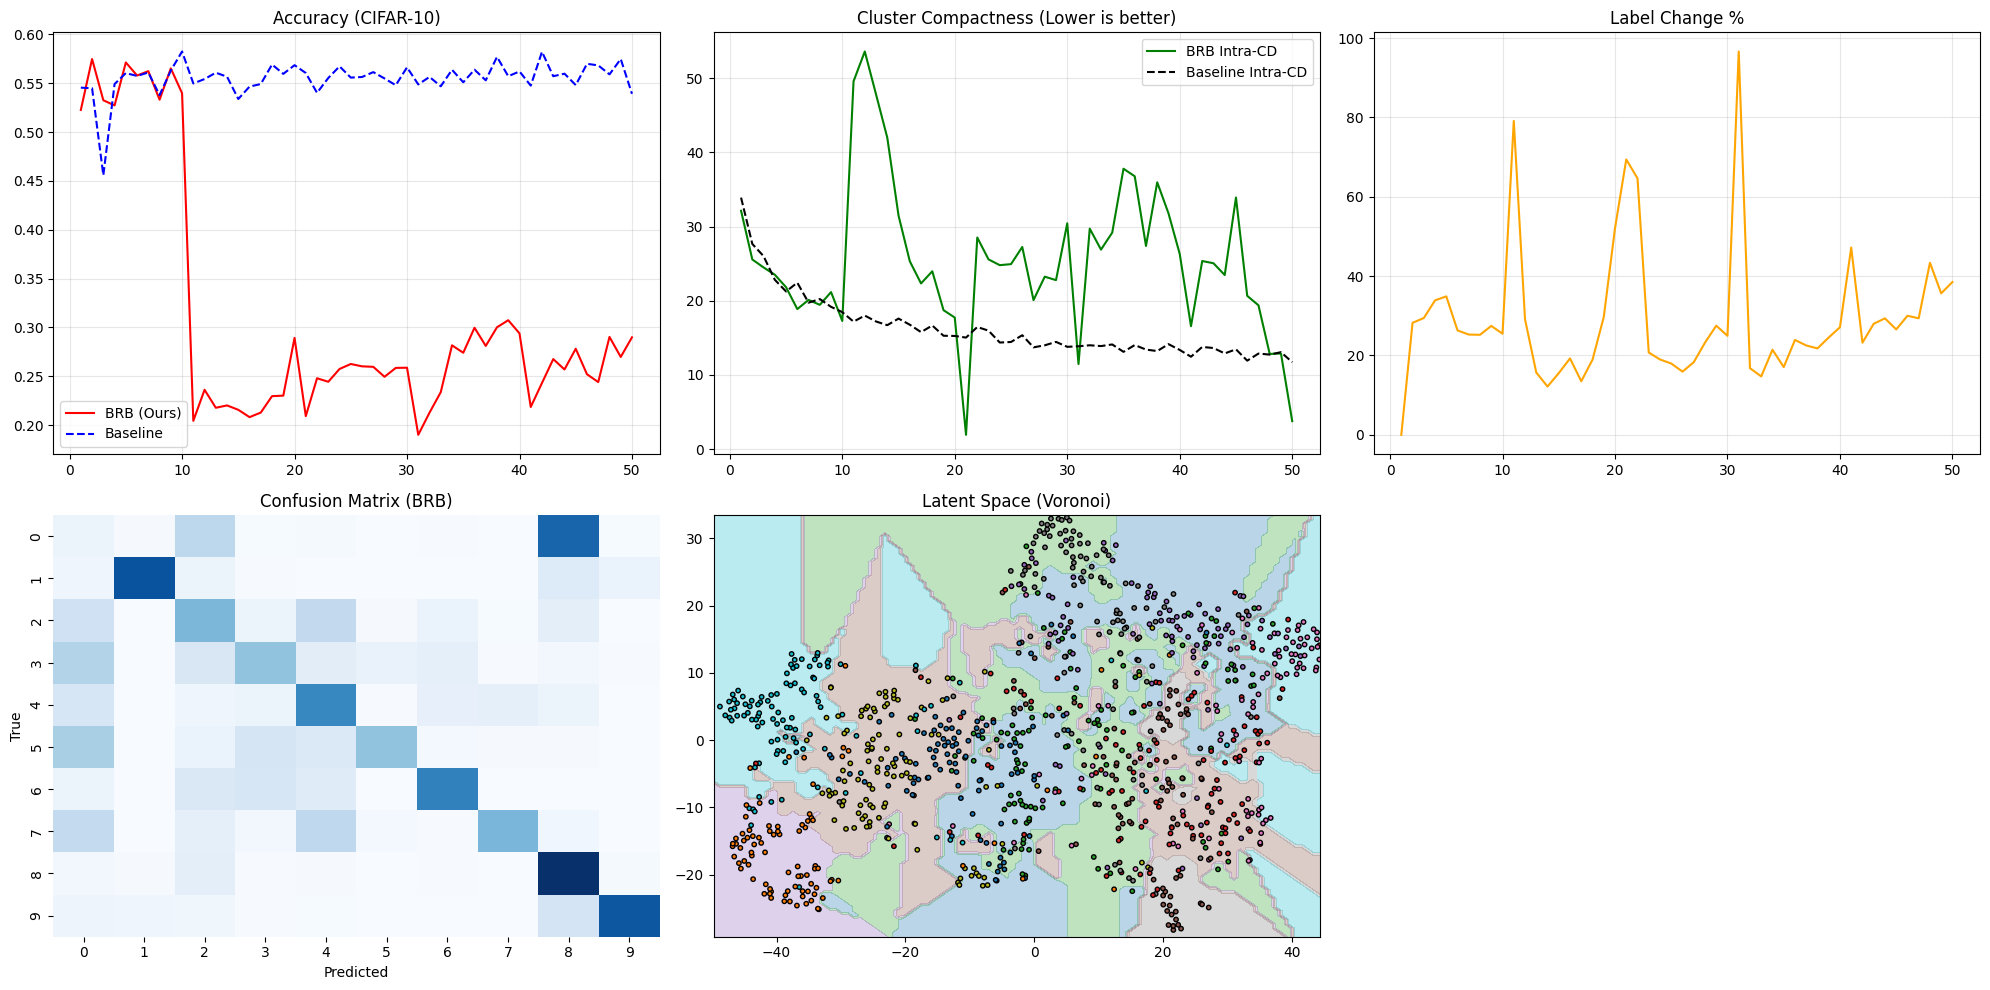

In [ ]:
print("\n>>> LOADING RESULTS & VISUALIZING...")

with open(f'history_baseline_{DATASET}.pkl', 'rb') as f:
    hist_base = pickle.load(f)
with open(f'history_brb_{DATASET}.pkl', 'rb') as f:
    hist_brb = pickle.load(f)

if 'model_brb' in locals():
    plot_visualizations(hist_brb, hist_base, model_brb, test_loader, DEVICE, DATASET, (DATASET=='CIFAR-10'))
else:
    print("Warning")
